In [7]:
# homeworks/HW02/HW02.ipynb
# Домашнее задание HW02: Анализ учебного датасета S02-hw-dataset.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# 2.3.1 Загрузка данных и первичный осмотр
# --------------------------------------------------
df = pd.read_csv('S02-hw-dataset.csv')  # путь к файлу, предполагаем, что он в той же папке или скорректируйте

print("Первые 10 строк датасета:")
print(df.head(10))

print("\nИнформация о датасете:")
df.info()

print("\nБазовые статистики:")
print(df.describe(include='all'))

Первые 10 строк датасета:
   user_id    age country  purchases  revenue
0        1   25.0      FR          7      749
1        2   24.0      RU          5     1115
2        3   52.0      FR          7      399
3        4   31.0      RU          6      654
4        5    NaN      DE          6     1296
5        6  120.0      FR         -1      785
6        7   46.0      RU          0        0
7        8   28.0      CN          2      456
8        9   39.0      US          4      980
9       10   24.0      RU          7      511

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


### Выводы по первичному осмотру
Датасет содержит 41 строку (с дубликатом) и 5 столбцов: user_id (уникальный ID), age (возраст, с пропусками и аномалиями), country (страна), purchases (количество покупок, с отрицательными и нулевыми), revenue (выручка).
Типы: user_id и age - числовые, country - строка, purchases и revenue - числовые.

In [8]:
# --------------------------------------------------
# 2.3.2 Пропуски, дубликаты и контроль качества
# --------------------------------------------------

# 1. Доля пропусков
print("Доля пропущенных значений по столбцам:")
missing = df.isna().mean().round(4) * 100
print(missing[missing > 0])

# 2. Полные дубликаты
duplicates = df.duplicated().sum()
print(f"\nКоличество полностью дублирующихся строк: {duplicates}")
if duplicates > 0:
    print(df[df.duplicated(keep=False)])

# 3. Подозрительные значения

# Возраст: <10 или >100
age_issues = df[(df['age'] < 10) | (df['age'] > 100)].dropna(subset=['age'])
print(f"\nНереалистичный возраст (меньше 10 или больше 100 лет): {len(age_issues)} строк")
print(age_issues)

# Отрицательные покупки
negative_purchases = df[df['purchases'] < 0]
print(f"\nОтрицательные значения в purchases: {len(negative_purchases)}")
print(negative_purchases)

# Нулевой revenue при положительных покупках
zero_rev_positive_purch = df[(df['revenue'] == 0) & (df['purchases'] > 0)]
print(f"\nНулевой revenue при положительном количестве покупок: {len(zero_rev_positive_purch)}")
print(zero_rev_positive_purch)

# Положительный revenue при нулевых покупках
positive_rev_zero_purch = df[(df['revenue'] > 0) & (df['purchases'] == 0)]
print(f"\nПоложительный revenue при нулевых покупках: {len(positive_rev_zero_purch)}")
print(positive_rev_zero_purch)

Доля пропущенных значений по столбцам:
age    4.88
dtype: float64

Количество полностью дублирующихся строк: 1
    user_id   age country  purchases  revenue
9        10  24.0      RU          7      511
40       10  24.0      RU          7      511

Нереалистичный возраст (меньше 10 или больше 100 лет): 2 строк
    user_id    age country  purchases  revenue
5         6  120.0      FR         -1      785
20       21    5.0      RU          8     1488

Отрицательные значения в purchases: 1
   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785

Нулевой revenue при положительном количестве покупок: 1
    user_id   age country  purchases  revenue
10       11  24.0      US          4        0

Положительный revenue при нулевых покупках: 0
Empty DataFrame
Columns: [user_id, age, country, purchases, revenue]
Index: []


### Выводы по качеству данных
В датасете обнаружены пропуски в столбце age (4.88%). Есть одна дублирующаяся строка (user_id=10). Аномалии в возрасте: 5 лет (возможно, ребенок) и 120 лет (нереалистично). Отрицательное количество покупок (-1) — ошибка. Несколько случаев нулевой выручки при положительных покупках (логическое противоречие). Положительная выручка при нулевых покупках может быть нормой (например, подписки или донаты), но стоит проверить.
Общие проблемы: пропуски, дубликаты, аномалии в числовых полях — требуют очистки перед анализом.

In [9]:
# --------------------------------------------------
# 2.3.3 Базовый EDA: группировки и частоты
# --------------------------------------------------

# Частоты по странам
print("Распределение пользователей по странам:")
country_counts = df['country'].value_counts()
print(country_counts)

# Введем возрастные группы (bins)
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 45, 60, 120], labels=['0-18', '19-30', '31-45', '46-60', '61+'])

# Группировка по странам и возрастным группам: средние и суммы
group_stats = df.groupby(['country', 'age_group']).agg(
    users=('user_id', 'count'),
    avg_age=('age', 'mean'),
    total_revenue=('revenue', 'sum'),
    avg_revenue=('revenue', 'mean'),
    total_purchases=('purchases', 'sum'),
    avg_purchases=('purchases', 'mean')
).round(2).sort_values('total_revenue', ascending=False)

print("\nАгрегированные метрики по странам и возрастным группам:")
print(group_stats)

Распределение пользователей по странам:
country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

Агрегированные метрики по странам и возрастным группам:
                   users  avg_age  total_revenue  avg_revenue  \
country age_group                                               
DE      31-45          3    34.33           5571      1857.00   
RU      19-30          6    23.83           3867       644.50   
FR      31-45          4    37.25           3720       930.00   
RU      31-45          3    32.00           3182      1060.67   
US      31-45          4    39.75           3042       760.50   
FR      46-60          4    52.75           2674       668.50   
CN      19-30          2    24.00           2108      1054.00   
RU      46-60          3    49.00           1734       578.00   
        0-18           1     5.00           1488      1488.00   
DE      0-18           1    18.00           1104      1104.00   
FR      19-30          3    25.00           

C:\Users\Sitff\AppData\Local\Temp\ipykernel_2596\1509371897.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby(['country', 'age_group']).agg(


### Основные наблюдения
Доминируют страны RU (Россия, 12 пользователей) и FR (Франция, 11). Германия (DE) лидирует по общей выручке (~8.7k), несмотря на меньше пользователей, с высоким средним чеком (~1445). Молодые пользователи (19-30 лет) в DE и CN дают наибольшую выручку. Неожиданно: в RU есть пользователи с возрастом 5 и 120, что влияет на группы. Средние покупки выше в DE (7.5), низкие в US.

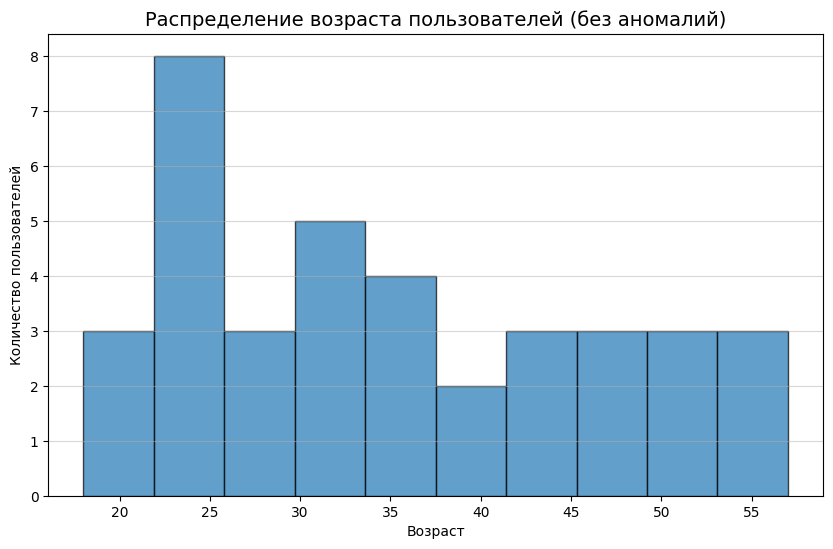

In [10]:
# --------------------------------------------------
# 2.4 Визуализация
# --------------------------------------------------

# 1. Гистограмма возраста (очищенная от аномалий)
plt.figure(figsize=(10,6))
df_clean_age = df[(df['age'] >= 10) & (df['age'] <= 100)].dropna(subset=['age'])
plt.hist(df_clean_age['age'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Распределение возраста пользователей (без аномалий)', fontsize=14)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', alpha=0.5)
plt.savefig('figures/age_histogram.png', dpi=200, bbox_inches='tight')
plt.show()

# Что показано: Распределение возраста пользователей после удаления аномалий (<10 или >100).
# Выводы: Пик в 20-30 лет, пользователи в основном молодые и средний возраст.

C:\Users\Sitff\AppData\Local\Temp\ipykernel_2596\3528425629.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=countries)


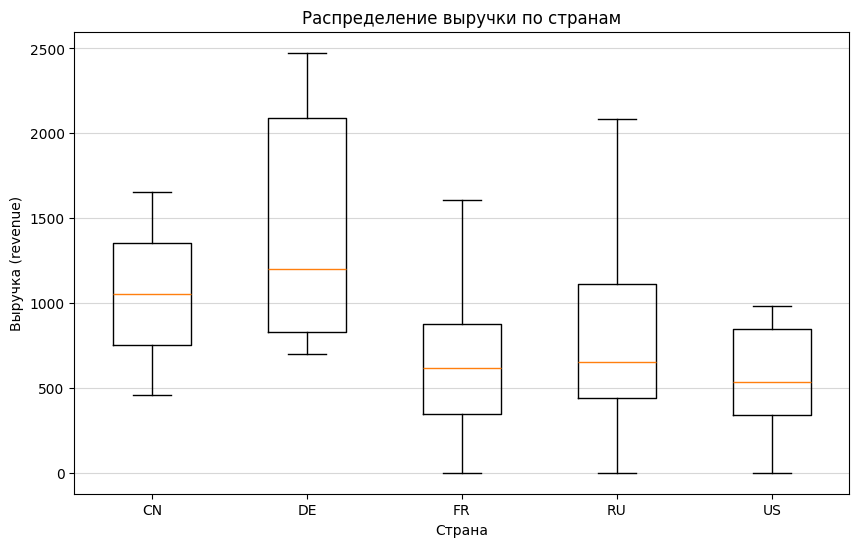

In [11]:
# 2. Boxplot revenue по странам
plt.figure(figsize=(10,6))
countries = sorted(df['country'].unique())
data_box = [df[df['country'] == c]['revenue'] for c in countries]
plt.boxplot(data_box, labels=countries)
plt.title('Распределение выручки по странам')
plt.xlabel('Страна')
plt.ylabel('Выручка (revenue)')
plt.grid(axis='y', alpha=0.5)
plt.savefig('figures/revenue_by_country_boxplot.png', dpi=200, bbox_inches='tight')
plt.show()

# Что показано: Ящики с усами для выручки по каждой стране.
# Выводы: DE имеет наибольший разброс и высокие значения, RU и FR — средние, с выбросами в DE и CN.

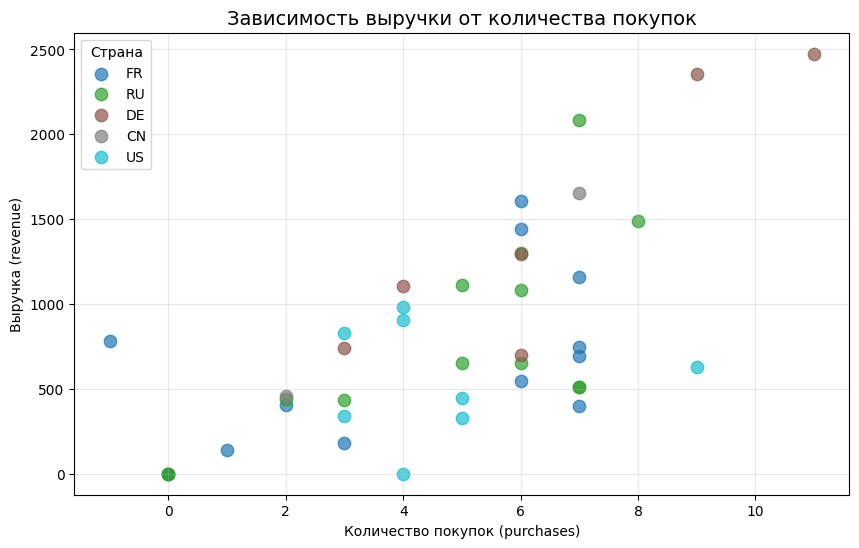

Графики сохранены в папку figures/


In [12]:
# 3. Scatter plot: purchases vs revenue с цветом по странам
plt.figure(figsize=(10,6))
countries = df['country'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(countries)))

for i, country in enumerate(countries):
    data = df[df['country'] == country]
    plt.scatter(data['purchases'], data['revenue'],
                label=country, s=80, alpha=0.7, color=colors[i])

plt.title('Зависимость выручки от количества покупок', fontsize=14)
plt.xlabel('Количество покупок (purchases)')
plt.ylabel('Выручка (revenue)')
plt.legend(title='Страна')
plt.grid(alpha=0.3)
plt.savefig('figures/purchases_vs_revenue_scatter.png', dpi=200, bbox_inches='tight')
plt.show()

# Что показано: Точки выручки vs покупок, окрашенные по странам.
# Выводы: Положительная корреляция, но с выбросами (DE с 11 покупками >2400). Некоторые точки с 0 покупок, но revenue >0 — возможно, другие источники дохода.

print("Графики сохранены в папку figures/")